In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import numpy as np 

In [29]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image

data_dir = "q2_data"  # Path to the dataset folder
# -----------------------
# 1. Dataset Loader with Train-Test Split
# -----------------------
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, image_size=(28, 28), flatten=True):
        self.image_paths = image_paths
        self.labels = labels
        self.image_size = image_size
        self.flatten = flatten

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        # Load and preprocess image
        image = Image.open(img_path).convert("L")  # Grayscale
        image = image.resize(self.image_size)

        # Normalize image
        image = np.array(image, dtype=np.float32) / 255.0  # Normalize to [0, 1]
        image = (image - 0.5) / 0.5                        # Normalize to [-1, 1]

        if self.flatten:
            image = image.flatten()  # For MLP: (784,)
            image_tensor = torch.tensor(image, dtype=torch.float32)
        else:
            image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # (1, 28, 28)

        label_tensor = torch.tensor(self.labels[idx], dtype=torch.long)

        return image_tensor, label_tensor


# -----------------------
# 2. Data Loading and Train-Test Split
# -----------------------
def load_dataset(data_dir, image_size=(28, 28), flatten=True, train_ratio=0.8):
    image_paths = []
    labels = []

    # Collect image paths and labels
    for label in sorted(os.listdir(data_dir)):  # Folders 0-9
        label_dir = os.path.join(data_dir, label)
        if os.path.isdir(label_dir):
            for img_file in os.listdir(label_dir):
                image_paths.append(os.path.join(label_dir, img_file))
                labels.append(int(label))

    # Convert to numpy arrays for easier slicing
    image_paths = np.array(image_paths)
    labels = np.array(labels)

    # Perform train-test split
    n_samples = len(image_paths)
    n_train = int(n_samples * train_ratio)

    indices = np.random.permutation(n_samples)
    train_indices, test_indices = indices[:n_train], indices[n_train:]

    # Create train and test datasets
    train_dataset = ImageDataset(image_paths[train_indices], labels[train_indices], image_size, flatten)
    test_dataset = ImageDataset(image_paths[test_indices], labels[test_indices], image_size, flatten)

    return train_dataset, test_dataset


# -----------------------
# 3. Example Usage
# -----------------------
# data_dir = "q2_data"  # Path to the dataset folder

# # Load datasets
# train_dataset, test_dataset = load_dataset(data_dir)

# # Create data loaders
# batch_size = 32
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")


## MLP

In [30]:
# -----------------------
# 2. Load the Dataset
# -----------------------
dataset_mlp, dataset_mlp_test = load_dataset(data_dir, flatten=True)
# dataset_mlp = ImageDataset(data_dir, flatten=True)
dataloader_mlp = DataLoader(dataset_mlp, batch_size=64, shuffle=True)

In [31]:


# -----------------------
# 3. MLP Model
# -----------------------
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)  # 10 classes
        )

    def forward(self, x):
        return self.model(x)

# -----------------------
# 4. Training Loop
# -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5

for epoch in range(num_epochs):
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in dataloader_mlp:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Accuracy calculation
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Accuracy: {accuracy:.2f}%")

# -----------------------
# 5. Save the Model
# -----------------------
torch.save(model.state_dict(), "mlp_model.pth")
print("Model saved successfully!")

#Print confusion matrix for all the multi class classification models and compare them using following
#  metrics : Accuracy, precision, recall and F1 score for each class and compare the results.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------
# 6. Load the Model
# -----------------------
model = MLP().to(device)
model.load_state_dict(torch.load("mlp_model.pth"))
model.eval()

# -----------------------
# 7. Confusion Matrix
# -----------------------
y_true = []
y_pred = []

for images, labels in dataloader_mlp:
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    y_true.extend(labels.cpu().numpy())
    y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Using device: cuda
Epoch [1/5], Loss: 86.7187, Accuracy: 77.81%
Epoch [2/5], Loss: 44.0557, Accuracy: 89.33%
Epoch [3/5], Loss: 32.5295, Accuracy: 91.69%
Epoch [4/5], Loss: 27.2577, Accuracy: 93.26%
Epoch [5/5], Loss: 19.5647, Accuracy: 95.28%
Model saved successfully!
Confusion Matrix:
[[796   0   0   0   0   3   0   0   5   2]
 [  0 771   2   2   1   1   0   1   4   6]
 [  0   0 757   6   5   0   1   7   7   2]
 [  0   4   4 752   0   9   0   1  14   7]
 [  0   4   2   0 740   0   0   2   0  44]
 [  1   2   0   5   0 791   0   0  16   4]
 [ 11   3   7   1  18  20 716   0  21   1]
 [  1   3   4   1   1   3   0 788   3  20]
 [  0   1   2   2   1   1   0   0 784   2]
 [  1   0   0   4   2   0   0   4   5 788]]


In [34]:
test_set = dataset_mlp_test
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

# MLP model is model
model.eval()
y_true = []
y_pred = []

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    y_true.extend(labels.cpu().numpy())
    y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)
# accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")
# classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))


Confusion Matrix:
[[188   0   1   1   0   3   0   0   1   0]
 [  0 211   0   0   0   0   0   0   0   1]
 [  2   2 193   5   4   0   1   2   6   0]
 [  0   0   1 193   0   4   0   5   3   3]
 [  0   0   1   0 195   0   1   1   0  10]
 [  1   1   0   7   0 164   2   0   3   3]
 [  3   3   3   0   3   8 178   0   4   0]
 [  0   0   1   1   0   0   0 161   0  13]
 [  1   2   0   1   1   2   0   0 197   3]
 [  0   0   0   4   3   1   0   1   2 185]]
Accuracy: 0.9325
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       194
           1       0.96      1.00      0.98       212
           2       0.96      0.90      0.93       215
           3       0.91      0.92      0.92       209
           4       0.95      0.94      0.94       208
           5       0.90      0.91      0.90       181
           6       0.98      0.88      0.93       202
           7       0.95      0.91      0.93       176
           8       0.91 

In [33]:
def test_image_mlp(path, model, flatten = True):
    image = Image.open(path).convert("L")
    image = image.resize((28, 28))
    # Normalize image
    image = np.array(image, dtype=np.float32) / 255.0  # Normalize to [0, 1]
    # test
    image = (image - 0.5) / 0.5
    image = image.flatten()
    image_tensor = torch.tensor(image, dtype=torch.float32).to(device)
    image_tensor = image_tensor.unsqueeze(0)
    output = model(image_tensor)
    _, predicted = torch.max(output, 1)
    print(f"Predicted label: {predicted.item()}")
    # class probabilities
    probs = torch.softmax(output, dim=1)
    probs = [f"{p:.4f}" for p in probs.squeeze().tolist()]
    return predicted, probs

In [ ]:
p, prob = test_image_mlp("q2_data/3/50.jpg", model)
print(f"Class probabilities: {prob}")

Predicted label: 3
Class probabilities: ['0.0008', '0.0006', '0.0007', '0.9840', '0.0000', '0.0124', '0.0000', '0.0000', '0.0015', '0.0001']
Predicted label: 3


## CNN

In [35]:
# -----------------------
# 2. Load the Dataset
# -----------------------
dataset_cnn, dataset_cnn_test = load_dataset(data_dir, flatten=False)
dataloader_cnn = DataLoader(dataset_cnn, batch_size=64, shuffle=True)
# -----------------------
# 3. CNN Model
# -----------------------
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # (28x28) → (28x28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # (28x28) → (14x14)

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # (14x14) → (14x14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)                    # (14x14) → (7x7)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),  # Fully connected layer
            nn.ReLU(),
            nn.Linear(128, 10)           # 10 classes
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten before FC layers
        x = self.fc_layers(x)
        return x

# -----------------------
# 4. Training Loop
# -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5

for epoch in range(num_epochs):
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in dataloader_cnn:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Accuracy calculation
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Accuracy: {accuracy:.2f}%")

# -----------------------
# 5. Save the Model
# -----------------------
torch.save(model.state_dict(), "cnn_model.pth")
print("CNN model saved successfully!")


# -----------------------
# 6. Load the Model
# -----------------------

model = CNN().to(device)
model.load_state_dict(torch.load("cnn_model.pth"))
model.eval()

# -----------------------
# 7. Confusion Matrix
# -----------------------
y_true = []
y_pred = []

for images, labels in dataloader_cnn:
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    y_true.extend(labels.cpu().numpy())
    y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Using device: cuda
Epoch [1/5], Loss: 77.9326, Accuracy: 80.89%
Epoch [2/5], Loss: 16.7518, Accuracy: 96.10%
Epoch [3/5], Loss: 10.6209, Accuracy: 97.36%
Epoch [4/5], Loss: 8.0972, Accuracy: 98.14%
Epoch [5/5], Loss: 6.5579, Accuracy: 98.55%
CNN model saved successfully!
Confusion Matrix:
[[786   0   1   0   0   1   1   2   0   0]
 [  1 822   1   0   0   0   0   0   0   1]
 [  0   2 790   1   1   0   1   4   3   0]
 [  0   0   0 785   0   1   0   1   0   0]
 [  0   1   0   0 806   0   0   2   0   1]
 [  0   0   0   2   0 785   0   0   0   0]
 [  1   0   0   0   0  10 784   0   1   0]
 [  0   2   0   0   1   0   0 789   0   0]
 [  0   0   0   1   0   4   0   0 792   0]
 [  0   0   0   5   1   3   0   7   2 795]]


In [36]:
# test set
test_set = dataset_cnn_test
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

# CNN model is model
model.eval()
y_true = []
y_pred = []

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    y_true.extend(labels.cpu().numpy())
    y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[204   0   0   0   0   1   3   1   0   0]
 [  0 170   0   1   1   0   0   3   0   0]
 [  0   0 193   0   0   0   0   2   3   0]
 [  1   0   0 203   0   3   0   1   2   3]
 [  0   2   0   0 182   0   2   1   2   1]
 [  0   0   0   1   0 212   0   0   0   0]
 [  0   0   0   0   0   2 201   0   1   0]
 [  0   0   2   0   0   0   0 203   1   2]
 [  1   0   1   2   0   1   1   1 195   1]
 [  0   0   0   2   4   1   0   4   0 176]]


In [ ]:
def test_image_cnn(path, model):
    """
    Tests a single image using the CNN model.

    Args:
    - path (str): Path to the image file.
    - model (torch.nn.Module): The trained CNN model.

    Returns:
    - predicted (int): Predicted label.
    - probs (list): List of class probabilities.
    """
    # -----------------------
    # 1. Load and Preprocess the Image
    # -----------------------
    image = Image.open(path).convert("L")      # Grayscale
    image = image.resize((28, 28))             # Resize to match model input
    image = np.array(image, dtype=np.float32) / 255.0   # Normalize to [0, 1]
    image = (image - 0.5) / 0.5                # Normalize to [-1, 1]

    # Convert to tensor format for CNN (1, 1, 28, 28)
    image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    # -----------------------
    # 2. Model Inference
    # -----------------------
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)

        # Class probabilities
        probs = torch.softmax(output, dim=1).squeeze().tolist()
        probs = [f"{p:.4f}" for p in probs]

    # -----------------------
    # 3. Output Prediction
    # -----------------------
    print(f"Predicted label: {predicted.item()}")
    return predicted.item(), probs


In [5]:
p, prob = test_image_cnn("q2_data/3/50.jpg", model)
print(f"Class probabilities: {prob}")

Predicted label: 3
Class probabilities: ['0.0000', '0.0000', '0.0000', '1.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000']


## PCA


In [47]:
image_size = (28, 28)
data = []
labels = []

def preprocess_img(img):
    img_array = np.array(img, dtype=np.float32) / 255.0
    img_array = img_array.flatten()  # Flatten to (784,)
    return img_array

def postprocess_img(img_array):
    img_array = img_array * 255.0
    img_array = img_array.reshape(image_size)
    img_array = np.clip(img_array, 0, 255).astype(np.uint8)
    return Image.fromarray(img_array)

# Load images
for label in sorted(os.listdir(data_dir)):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):
        for img_file in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_file)
            image = Image.open(img_path)
            img_array = preprocess_img(image)
            data.append(img_array)
            labels.append(int(label))

data = np.array(data)
labels = np.array(labels)

# Mean-centering the data
mean = np.mean(data, axis=0)
data_centered = data - mean

# PCA with mean-centered data
C = np.cov(data_centered.T)
eigenvalues, eigenvectors = np.linalg.eig(C)

# Sort eigenvalues and eigenvectors in descending order
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# Image reconstruction
ks = [1,2,5,8, 10,15,20, 50, 100, 400, 784]

img_path = "q2_data/3/50.jpg"
image = Image.open(img_path)
image = np.array(image, dtype=np.float32) / 255.0
image = image.flatten()

# Center the image using the same mean
image_centered = image - mean

# Reconstruct images at different k values
for k in ks:
    P = eigenvectors[:, :k]
    
    # Project the image
    projected_image = np.dot(image_centered, P)

    # Reconstruct the image
    reconstructed_image = np.dot(projected_image, P.T) + mean  # Add the mean back
    reconstructed_image = postprocess_img(reconstructed_image)
    
    reconstructed_image.save(f"PCA_reconstructed_img/{k}.jpg")

# Save the original image for reference
image = postprocess_img(image)
image.save("PCA_reconstructed_img/original.jpg")


/tmp/ipykernel_73578/24334523.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  img_array = np.clip(img_array, 0, 255).astype(np.uint8)


## MLP with PCA

In [48]:
k = 100
P = eigenvectors[:, :k]

# Project data to k-dimensional space
projected_data = np.dot(data, P)

In [39]:
# -----------------------
# 1. Dataset Loader with PCA Projection
# -----------------------
class PCAImageDataset(Dataset):
    def __init__(self, projected_data, labels):
        self.projected_data = projected_data
        self.labels = labels

    def __len__(self):
        return len(self.projected_data)

    def __getitem__(self, idx):
        image_tensor = torch.tensor(self.projected_data[idx], dtype=torch.float32)
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.long)
        return image_tensor, label_tensor

# -----------------------
# 2. Data Preprocessing and PCA
# -----------------------
# Parameters
data_dir = "q2_data"
image_size = (28, 28)

# -----------------------
# 3. Create Dataset and Dataloader with PCA Data
# -----------------------
dataset_pca = PCAImageDataset(projected_data, labels)
dataloader_pca = DataLoader(dataset_pca, batch_size=64, shuffle=True)

# -----------------------
# 4. MLP Model for PCA Data
# -----------------------
class MLP_PCA(nn.Module):
    def __init__(self, input_dim=k):
        super(MLP_PCA, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)          # 10 classes
        )

    def forward(self, x):
        return self.model(x)

# -----------------------
# 5. Training Loop
# -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model, loss, optimizer
model_pca = MLP_PCA(input_dim=k).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pca.parameters(), lr=0.001)

num_epochs = 5

for epoch in range(num_epochs):
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in dataloader_pca:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model_pca(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Accuracy calculation
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Accuracy: {accuracy:.2f}%")

# -----------------------
# 6. Save the Model
# -----------------------
torch.save(model_pca.state_dict(), "mlp_pca_model.pth")
print("MLP with PCA model saved successfully!")

# -----------------------
# 7. Load the Model
# -----------------------
model_pca = MLP_PCA(input_dim=k).to(device)
model_pca.load_state_dict(torch.load("mlp_pca_model.pth"))
model_pca.eval()

# -----------------------
# 8. Confusion Matrix
# -----------------------
y_true = []
y_pred = []

for images, labels in dataloader_pca:
    images, labels = images.to(device), labels.to(device)

    outputs = model_pca(images)
    _, predicted = torch.max(outputs, 1)

    y_true.extend(labels.cpu().numpy())
    y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)


Using device: cuda
Epoch [1/5], Loss: 89.0712, Accuracy: 84.70%
Epoch [2/5], Loss: 36.2515, Accuracy: 93.00%
Epoch [3/5], Loss: 23.7152, Accuracy: 95.49%
Epoch [4/5], Loss: 14.8870, Accuracy: 97.49%
Epoch [5/5], Loss: 10.2401, Accuracy: 98.25%
MLP with PCA model saved successfully!
Confusion Matrix:
[[999   0   0   0   0   0   0   0   0   1]
 [  1 992   2   2   0   0   0   3   0   0]
 [  0   0 995   0   1   0   0   3   1   0]
 [  0   0   9 987   0   1   0   2   0   1]
 [  0   3   0   0 986   0   0   5   0   6]
 [  4   0   0   2   0 991   2   1   0   0]
 [  5   0   3   0   1   0 991   0   0   0]
 [  1   1   2   0   1   0   0 994   0   1]
 [  3   0  30   1   0   0   0   1 965   0]
 [  1   0   0   2   2   0   0  11   2 982]]


In [46]:
print(len(label))

1


In [49]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim

# -----------------------
# 1. Dataset Loader with PCA Projection
# -----------------------
class PCAImageDataset(Dataset):
    def __init__(self, projected_data, labels):
        self.projected_data = projected_data
        self.labels = labels

    def __len__(self):
        return len(self.projected_data)

    def __getitem__(self, idx):
        image_tensor = torch.tensor(self.projected_data[idx], dtype=torch.float32)
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.long)
        return image_tensor, label_tensor

# -----------------------
# 2. Data Preprocessing and PCA
# -----------------------
# Parameters
data_dir = "q2_data"
image_size = (28, 28)

# -----------------------
# 3. Train-Test Split
# -----------------------
X_train, X_test, y_train, y_test = train_test_split(projected_data, labels, test_size=0.2, random_state=42)

# Create dataset and dataloader
train_dataset = PCAImageDataset(X_train, y_train)
test_dataset = PCAImageDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# -----------------------
# 4. MLP Model for PCA Data
# -----------------------
class MLP_PCA(nn.Module):
    def __init__(self, input_dim=k):
        super(MLP_PCA, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)          # 10 classes
        )

    def forward(self, x):
        return self.model(x)

# -----------------------
# 5. Training Loop
# -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model, loss, optimizer
model_pca = MLP_PCA(input_dim=k).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pca.parameters(), lr=0.001)

num_epochs = 5

for epoch in range(num_epochs):
    model_pca.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model_pca(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Accuracy calculation
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Accuracy: {accuracy:.2f}%")

# -----------------------
# 6. Save the Model
# -----------------------
torch.save(model_pca.state_dict(), "mlp_pca_model.pth")
print("MLP with PCA model saved successfully!")

# -----------------------
# 7. Load the Model
# -----------------------
model_pca = MLP_PCA(input_dim=k).to(device)
model_pca.load_state_dict(torch.load("mlp_pca_model.pth"))
model_pca.eval()

# -----------------------
# 8. Test Model and Confusion Matrix
# -----------------------
y_true = []
y_pred = []

model_pca.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model_pca(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix on Test Set:")
print(cm)


Using device: cuda
Epoch [1/5], Loss: 83.4311, Accuracy: 82.28%
Epoch [2/5], Loss: 31.6379, Accuracy: 92.54%
Epoch [3/5], Loss: 20.7335, Accuracy: 95.19%
Epoch [4/5], Loss: 14.4130, Accuracy: 96.61%
Epoch [5/5], Loss: 8.7968, Accuracy: 98.19%
MLP with PCA model saved successfully!

Confusion Matrix on Test Set:
[[204   0   1   1   0   0   1   0   0   1]
 [  1 193   1   0   1   0   0   0   6   0]
 [  2   1 181   0   1   0   3   1   3   0]
 [  0   0   5 187   0   5   0   1   1   2]
 [  0   0   1   0 199   0   3   0   0   6]
 [  1   1   1   1   0 179   0   0   1   2]
 [  1   1   2   0   0   1 206   0   0   0]
 [  0   0   6   1   2   3   0 189   0   3]
 [  3   0   5   1   1   3   4   0 193   2]
 [  0   0   0   5   4   1   0   2   0 163]]



Training One-vs-Rest Binary Classifiers...
Training binary classifier for class 0...
Training binary classifier for class 1...
Training binary classifier for class 2...
Training binary classifier for class 3...
Training binary classifier for class 4...
Training binary classifier for class 5...
Training binary classifier for class 6...
Training binary classifier for class 7...
Training binary classifier for class 8...
Training binary classifier for class 9...

Generating ROC Curves (One-vs-Rest)...
Generating ROC for class 0...
Generating ROC for class 1...
Generating ROC for class 2...
Generating ROC for class 3...
Generating ROC for class 4...
Generating ROC for class 5...
Generating ROC for class 6...
Generating ROC for class 7...
Generating ROC for class 8...
Generating ROC for class 9...


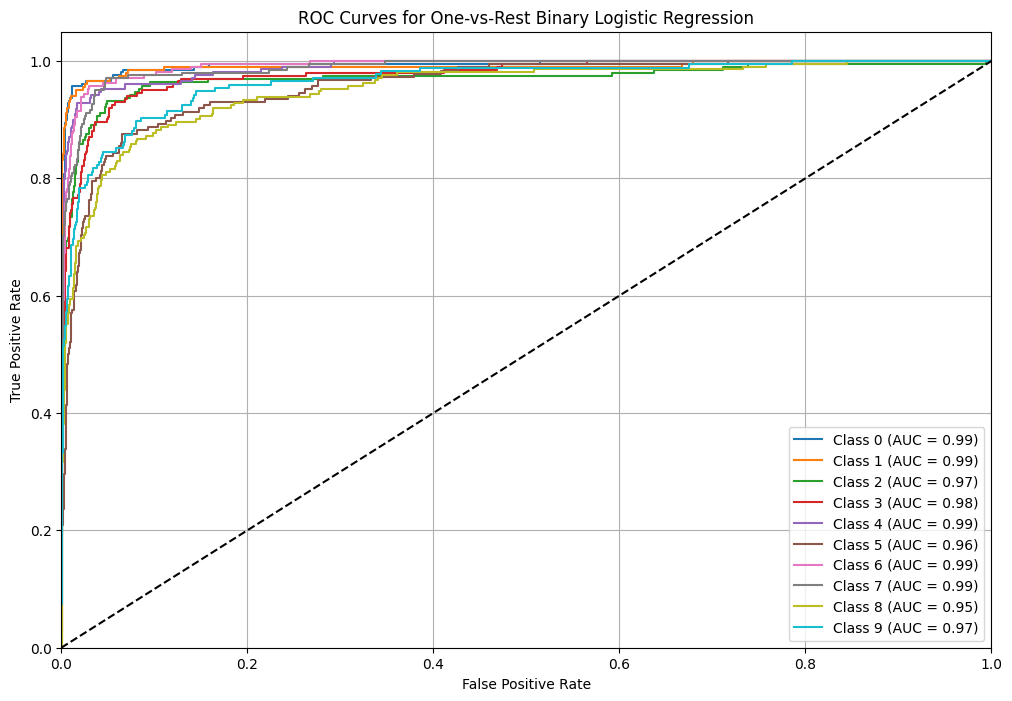


Generating Multiclass ROC and AUC...


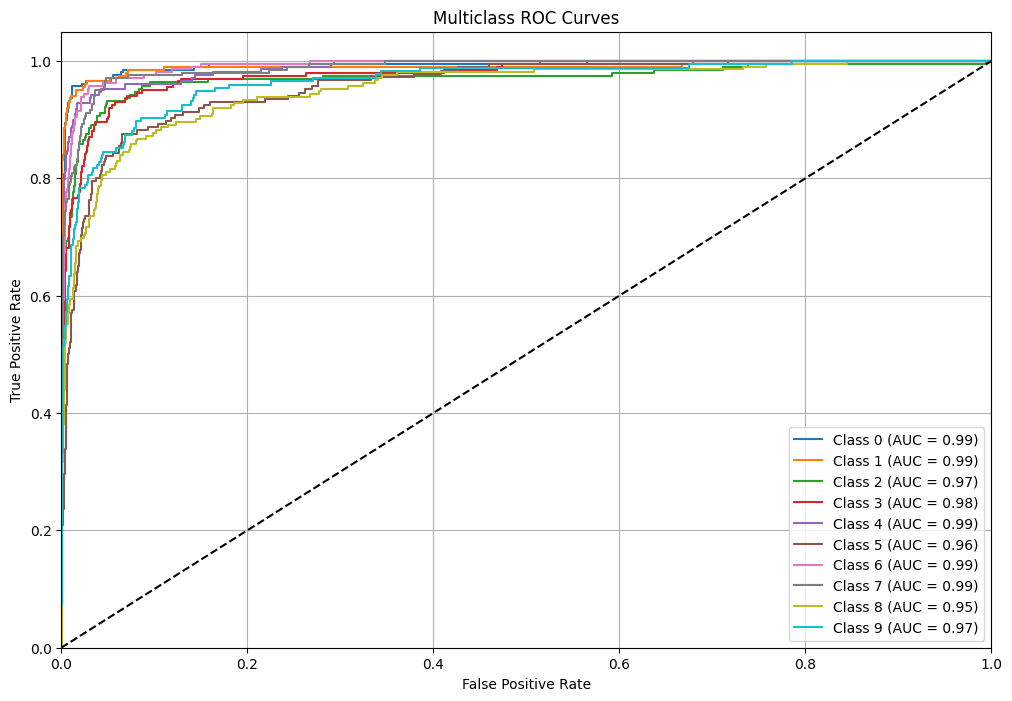

Confusion Matrix:
[[199   0   0   1   3   0   2   1   1   1]
 [  0 192   1   0   1   2   1   0   5   0]
 [  4   6 155   4   3   1   7   4   8   0]
 [  1   2   9 167   0  10   2   5   2   3]
 [  0   2   1   0 191   3   4   0   2   6]
 [  9   3   1  10   2 141   6   5   7   2]
 [  4   1   5   0   2   4 195   0   0   0]
 [  0   7   3   2   3   1   0 180   2   6]
 [  4   9   4   8   4  14   1   4 161   3]
 [  0   1   1   7   9   0   0  11   2 144]]


In [50]:
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# -----------------------
# 1. Preprocessing & PCA (Same as before)
# -----------------------
image_size = (28, 28)
data = []
labels = []

def preprocess_img(img):
    img_array = np.array(img, dtype=np.float32) / 255.0
    img_array = img_array.flatten()  # Flatten to (784,)
    return img_array

# Load the images
data_dir = "q2_data"
for label in sorted(os.listdir(data_dir)):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):
        for img_file in os.listdir(label_dir):
            img_path = os.path.join(data_dir, label, img_file)
            image = Image.open(img_path)
            img_array = preprocess_img(image)
            data.append(img_array)
            labels.append(int(label))

data = np.array(data)
labels = np.array(labels)

# Standardize the data (mean=0, variance=1)
scaler = StandardScaler()
data = scaler.fit_transform(data)

# PCA
m = np.mean(data, axis=0)
data -= m
C = np.cov(data.T)
eigenvalues, eigenvectors = np.linalg.eig(C)

# Sort eigenvalues and eigenvectors in descending order
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# Select top k components
k = 100
P = eigenvectors[:, :k]

# Project data onto PCA space
pca_data = np.dot(data, P)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(pca_data, labels, test_size=0.2, random_state=42)

# -----------------------
# 2. Logistic Regression Model
# -----------------------
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

class LogisticRegression:
    def __init__(self, lr=0.01, epochs=1000, tol=1e-5):
        self.lr = lr
        self.epochs = epochs
        self.tol = tol

    def fit(self, X, y):
        m, n = X.shape
        self.theta = np.zeros(n + 1)  # Initialize weights + bias
        X = np.hstack((X, np.ones((m, 1))))  # Add bias term

        for epoch in range(self.epochs):
            z = np.dot(X, self.theta)
            predictions = sigmoid(z)

            gradient = np.dot(X.T, (predictions - y)) / m
            self.theta -= self.lr * gradient

            # Convergence check
            if np.linalg.norm(gradient) < self.tol:
                break

    def predict_proba(self, X):
        m = X.shape[0]
        X = np.hstack((X, np.ones((m, 1))))  # Add bias term
        return sigmoid(np.dot(X, self.theta))

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

# -----------------------
# 3. One-vs-Rest Logistic Regression
# -----------------------
print("\nTraining One-vs-Rest Binary Classifiers...")

num_classes = len(np.unique(y_train))
binary_classifiers = {}

# Train 10 binary classifiers (one-vs-rest)
for c in range(num_classes):
    print(f"Training binary classifier for class {c}...")
    
    # Create binary labels for One-vs-Rest
    y_binary = (y_train == c).astype(int)

    clf = LogisticRegression(lr=0.01, epochs=2000)
    clf.fit(X_train, y_binary)

    binary_classifiers[c] = clf

# -----------------------
# 4. ROC and AUC Calculation (One-vs-Rest)
# -----------------------
print("\nGenerating ROC Curves (One-vs-Rest)...")

# Plot ROC for each binary classifier
plt.figure(figsize=(12, 8))

for c in range(num_classes):
    print(f"Generating ROC for class {c}...")

    # Create binary labels for test set
    y_test_binary = (y_test == c).astype(int)

    # Get predicted probabilities
    y_prob = binary_classifiers[c].predict_proba(X_test)

    # ROC and AUC
    fpr, tpr, _ = roc_curve(y_test_binary, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'Class {c} (AUC = {roc_auc:.2f})')

# Plot settings for one-vs-rest
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for One-vs-Rest Binary Logistic Regression')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# -----------------------
# 5. Multiclass ROC and AUC Calculation
# -----------------------
print("\nGenerating Multiclass ROC and AUC...")

# Binarize the labels for multiclass ROC calculation
y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))
y_train_bin = label_binarize(y_train, classes=np.arange(num_classes))

# Multiclass prediction probabilities
y_prob_multiclass = np.zeros((X_test.shape[0], num_classes))

# Collect probabilities for each class
for c in range(num_classes):
    y_prob_multiclass[:, c] = binary_classifiers[c].predict_proba(X_test)

# ROC and AUC for multiclass
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(12, 8))

# Plot ROC curve for each class
for c in range(num_classes):
    fpr[c], tpr[c], _ = roc_curve(y_test_bin[:, c], y_prob_multiclass[:, c])
    roc_auc[c] = auc(fpr[c], tpr[c])

    plt.plot(fpr[c], tpr[c], label=f'Class {c} (AUC = {roc_auc[c]:.2f})')

# Micro-average ROC and AUC
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_prob_multiclass.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Macro-average ROC and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= num_classes
roc_auc_macro = auc(all_fpr, mean_tpr)


# Plot settings for multiclass
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# -----------------------
# 6. Confusion Matrix
# -----------------------
y_true = y_test
y_pred = np.argmax(y_prob_multiclass, axis=1)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)


In [ ]:
def test_image_logistic(path, binary_classifiers, mean, eigenvectors, k, scaler):
    """
    Tests a single image using One-vs-Rest Logistic Regression with PCA.

    Args:
    - path (str): Path to the image.
    - binary_classifiers (dict): Dictionary of binary classifiers.
    - mean (np.array): Mean vector used for PCA.
    - eigenvectors (np.array): PCA eigenvectors.
    - k (int): Number of principal components.
    - scaler (StandardScaler): Scaler used to standardize the images.

    Returns:
    - predicted (int): Predicted label.
    - probs (list): Class probabilities.
    """
    # -----------------------
    # 1. Preprocessing the Image
    # -----------------------
    image = Image.open(path).convert("L")  # Grayscale
    image = image.resize((28, 28))         # Resize to match dataset
    img_array = np.array(image, dtype=np.float32) / 255.0
    img_array = img_array.flatten()        # Flatten to (784,)

    # -----------------------
    # 2. Standardize and Apply PCA
    # -----------------------
    img_array = scaler.transform([img_array])  # Standardize image

    # Center image using mean
    img_centered = img_array - mean

    # Project image onto PCA space
    P = eigenvectors[:, :k]
    img_pca = np.dot(img_centered, P)

    # -----------------------
    # 3. Model Inference
    # -----------------------
    probs = []
    for c in range(len(binary_classifiers)):
        clf = binary_classifiers[c]
        prob = clf.predict_proba(img_pca)[0]  # Get probability for class c
        probs.append(prob)

    # -----------------------
    # 4. Prediction
    # -----------------------
    # Get the class with the highest probability
    probs = np.array(probs).flatten()
    predicted = np.argmax(probs)

    # Format the probabilities
    probs_str = [f"{p:.4f}" for p in probs]

    print(f"\nPredicted Label: {predicted}")
    # print(f"Class Probabilities: {probs_str}")

    return predicted, probs_str


In [27]:
p, prob = test_image_logistic("q2_data/3/50.jpg", binary_classifiers, m, eigenvectors, k, scaler)
print(f"Class probabilities: {prob}")


Predicted Label: 3
Class Probabilities: ['0.1582', '0.1579', '0.0479', '0.7726', '0.0297', '0.1851', '0.0237', '0.0659', '0.0347', '0.0201']
Class probabilities: ['0.1582', '0.1579', '0.0479', '0.7726', '0.0297', '0.1851', '0.0237', '0.0659', '0.0347', '0.0201']
